# Diabetes Risk Analysis: Statistical Inference & Visual Storytelling

## 1. Project Background
This analysis explores the Pima Indians Diabetes dataset, focusing on clinical measurements for 768 female patients. Using statistical inference and data visualization, we seek to identify the most significant risk factors and physiological patterns associated with diabetes onset.

### 1.1 Methodology
Following the principles of **'Storytelling with Data'**, this notebook aims for clarity and impact. This version is optimized for **Google Colab**, featuring automated figure export and dataset extraction.

---

## 2. Environment Setup & Colab Configuration
We utilize the `tidyverse` suite alongside statistical inference packages.

In [2]:
required_packages <- c("tidyverse", "scales", "viridis", "gridExtra", "broom", "infer", "hexbin")
missing_packages <- required_packages[!(required_packages %in% installed.packages()[,"Package"])]
if(length(missing_packages)) install.packages(missing_packages, repos='http://cran.us.r-project.org')

library(tidyverse)
library(scales)
library(viridis)
library(gridExtra)
library(broom)
library(infer)
library(hexbin)

if (!dir.exists("figures")) dir.create("figures")

theme_premium <- function() {
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 16, color = "#2c3e50"),
    plot.subtitle = element_text(size = 12, color = "#7f8c8d", margin = margin(b = 15)),
    axis.title = element_text(face = "bold", color = "#34495e"),
    panel.grid.minor = element_blank(),
    legend.position = "top"
  )
}
theme_set(theme_premium())

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘patchwork’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal



Attaching package: ‘gridExtra’



### 2.1 Data Loading & Preprocessing
The dataset is loaded from a compressed CSV. During initial inspection, several clinical variables (Glucose, Blood Pressure, BMI, etc.) were found to contain `0` values, which are physiologically impossible for living patients. 

**Statistical Rationale for Cleansing:**
- **NA Conversion:** We convert `0` to `NA` for these specific columns to prevent biased means and skewed distributions during analysis.
- **Imputation vs. Exclusion:** For this exploratory phase, we retain the NAs to allow `na.rm = TRUE` in calculations, ensuring that the 'True Zero' doesn't dilute our risk assessment.

In [3]:
if (file.exists("diabetes_dataset.zip")) {
  unzip("diabetes_dataset.zip")
}

data <- read.csv("diabetes_dataset.csv")
data_clean <- data %>%
  mutate(across(c(Glucose, BloodPressure, SkinThickness, Insulin, BMI), ~na_if(., 0)))

message("Cleaning complete. Handling missing values:")
colSums(is.na(data_clean))

Cleaning complete. Handling missing values:



Pregnancies                  Glucose            BloodPressure 
                       0                        5                       35 
           SkinThickness                  Insulin                      BMI 
                     227                      374                       11 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

### 2.2 Numerical Summaries & Prevalence
High-level statistical breakdown of the dataset cohorts.

In [4]:
stats_comparison <- data_clean %>%
  group_by(Outcome) %>%
  summarise(
    Avg_Glucose = mean(Glucose, na.rm = TRUE),
    Avg_Age = mean(Age, na.rm = TRUE),
    Avg_BP = mean(BloodPressure, na.rm = TRUE),
    Avg_BMI = mean(BMI, na.rm = TRUE),
    Count = n()
  )
print(stats_comparison)

diabetes_rate <- prop.table(table(data$Outcome))
message("Global Diabetes Prevalence:")
print(diabetes_rate)

# A tibble: 2 × 6
  Outcome Avg_Glucose Avg_Age Avg_BP Avg_BMI Count
    <int>       <dbl>   <dbl>  <dbl>   <dbl> <int>
1       0        111.    31.2   70.9    30.9   500
2       1        142.    37.1   75.3    35.4   268


Global Diabetes Prevalence:




        0         1 
0.6510417 0.3489583 


### Task 1: The Glucose Gap
**Purpose:** This density plot compares the distribution of glucose levels between diabetic and non-diabetic cohorts. We expect to see a significant 'right-shift' in the diabetic group, identifying glucose concentration as a primary diagnostic indicator.

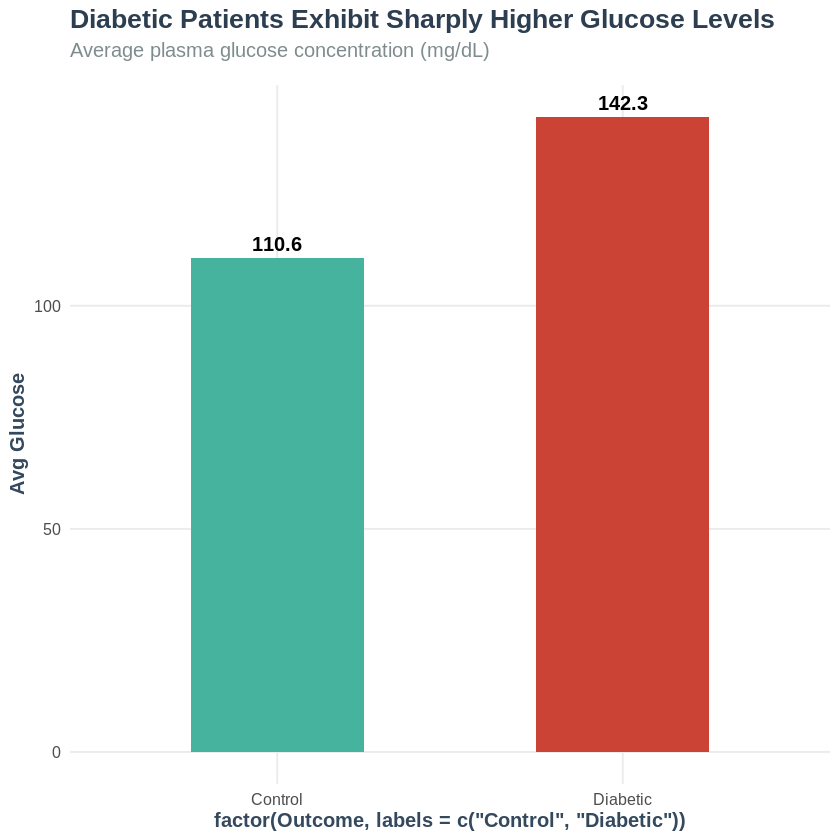

In [5]:
p1 <- data_clean %>%
  group_by(Outcome) %>%
  summarise(mean_val = mean(Glucose, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(Outcome, labels = c("Control", "Diabetic")), y = mean_val, fill = factor(Outcome))) +
  geom_col(width = 0.5, show.legend = FALSE) +
  geom_text(aes(label = round(mean_val, 1)), vjust = -0.5, fontface = "bold") +
  scale_fill_manual(values = c("#45B39D", "#CB4335")) +
  labs(title = "Diabetic Patients Exhibit Sharply Higher Glucose Levels",
       subtitle = "Average plasma glucose concentration (mg/dL)", y = "Avg Glucose")

print(p1)
ggsave("figures/task1_glucose_gap.png", plot = p1, width = 8, height = 6)

### Task 2: Age Progression
Comparing age distribution across diabetic and non-diabetic cohorts.

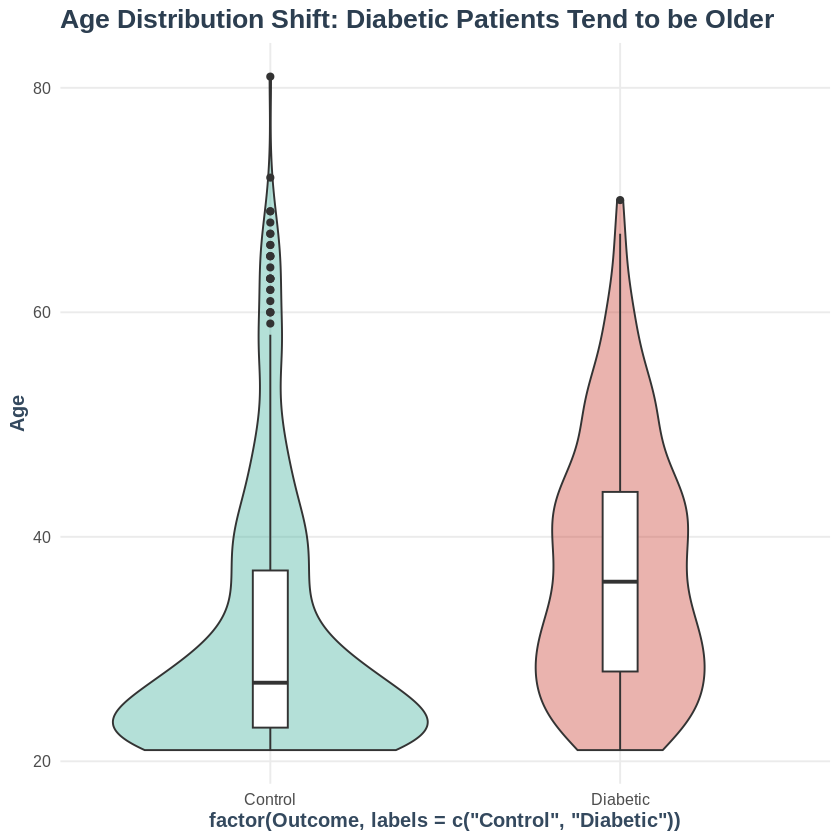

In [6]:
p2 <- ggplot(data_clean, aes(x = factor(Outcome, labels = c("Control", "Diabetic")), y = Age, fill = factor(Outcome))) +
  geom_violin(alpha = 0.4, show.legend = FALSE) + geom_boxplot(width = 0.1, fill = "white") +
  scale_fill_manual(values = c("#45B39D", "#CB4335")) +
  labs(title = "Age Distribution Shift: Diabetic Patients Tend to be Older", y = "Age")

print(p2)
ggsave("figures/task2_age_dist.png", plot = p2, width = 8, height = 6)

### Task 3 & 4: Physical Indicators (BMI & Blood Pressure)

Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


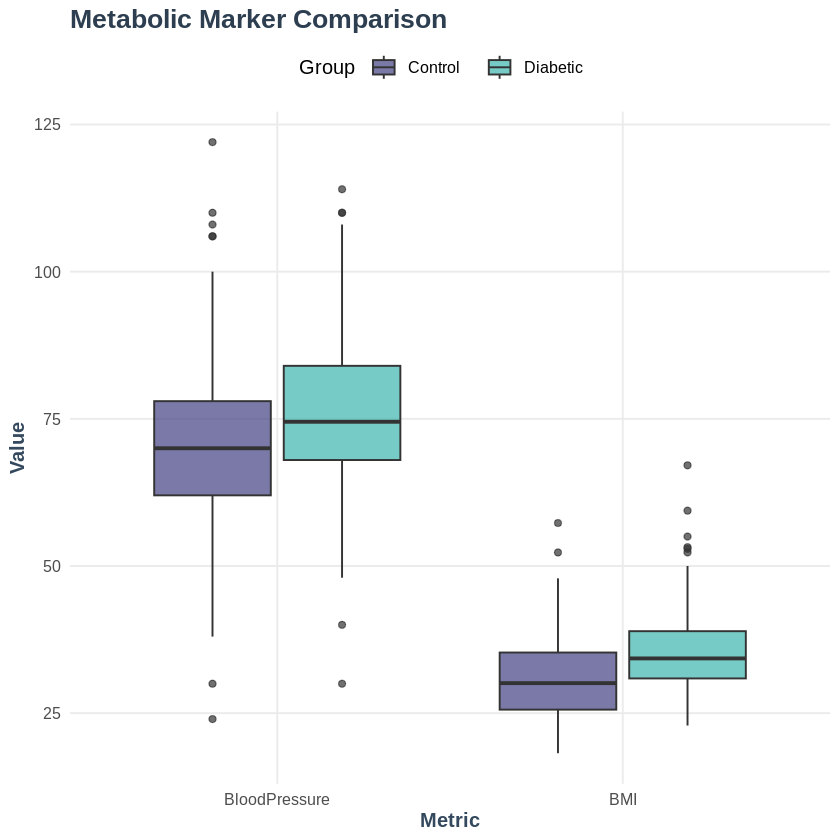

In [7]:
p3 <- data_clean %>%
  select(Outcome, BMI, BloodPressure) %>%
  pivot_longer(-Outcome, names_to = "Metric", values_to = "Value") %>%
  ggplot(aes(x = Metric, y = Value, fill = factor(Outcome, labels = c("Control", "Diabetic")))) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "mako", begin = 0.3, end = 0.7) +
  labs(title = "Metabolic Marker Comparison", fill = "Group", y = "Value")

print(p3)
ggsave("figures/task34_bmi_bp.png", plot = p3, width = 8, height = 6)

### Task 5: Diabetes Prevalence
**Purpose:** Establishing a baseline. This pie chart provides the 'ground truth' proportions of our sample, showing the imbalance between cohorts.

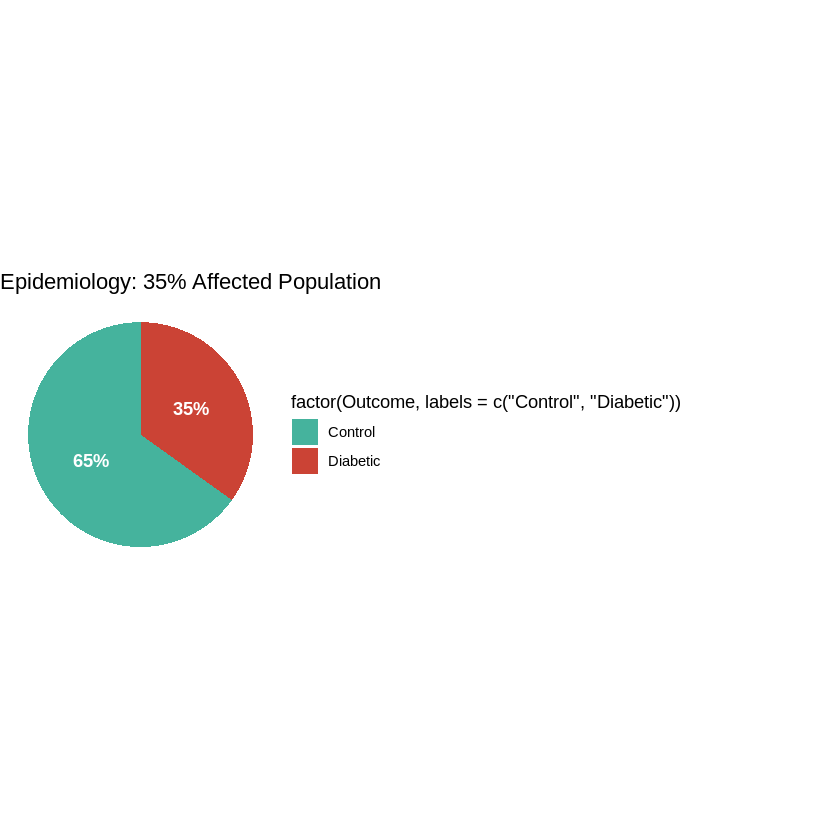

In [8]:
p5 <- data_clean %>%
  count(Outcome) %>%
  mutate(label = paste0(round(n/sum(n)*100), "%")) %>%
  ggplot(aes(x = "", y = n, fill = factor(Outcome, labels = c("Control", "Diabetic")))) +
  geom_bar(stat = "identity", width = 1) + coord_polar("y", start = 0) + theme_void() +
  geom_text(aes(label = label), position = position_stack(vjust = 0.5), color = "white", fontface = "bold") +
  scale_fill_manual(values = c("#45B39D", "#CB4335")) +
  labs(title = "Epidemiology: 35% Affected Population")

print(p5)
ggsave("figures/task5_prevalence.png", plot = p5, width = 6, height = 6)

### Task 6: BMI Distribution
**Purpose:** Understanding body mass density. This histogram highlights the frequency of obesity classes within our sample, helping to visualize central tendency.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 11 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range (`stat_bin()`).”


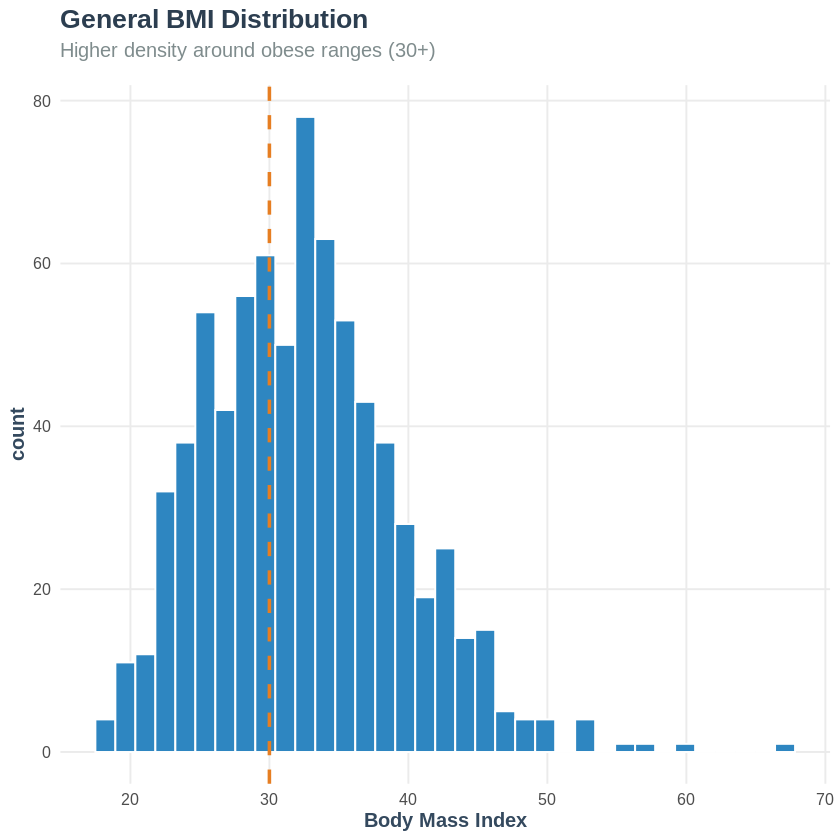

In [9]:
p6 <- ggplot(data_clean, aes(x = BMI)) +
  geom_histogram(fill = "#2e86c1", color = "white", bins = 35) +
  geom_vline(xintercept = 30, linetype = "dashed", color = "#e67e22", size = 1) +
  labs(title = "General BMI Distribution", subtitle = "Higher density around obese ranges (30+)", x = "Body Mass Index")

print(p6)
ggsave("figures/task6_bmi_hist.png", plot = p6, width = 8, height = 6)

### Task 7: Genetic Risk Density (DPF)

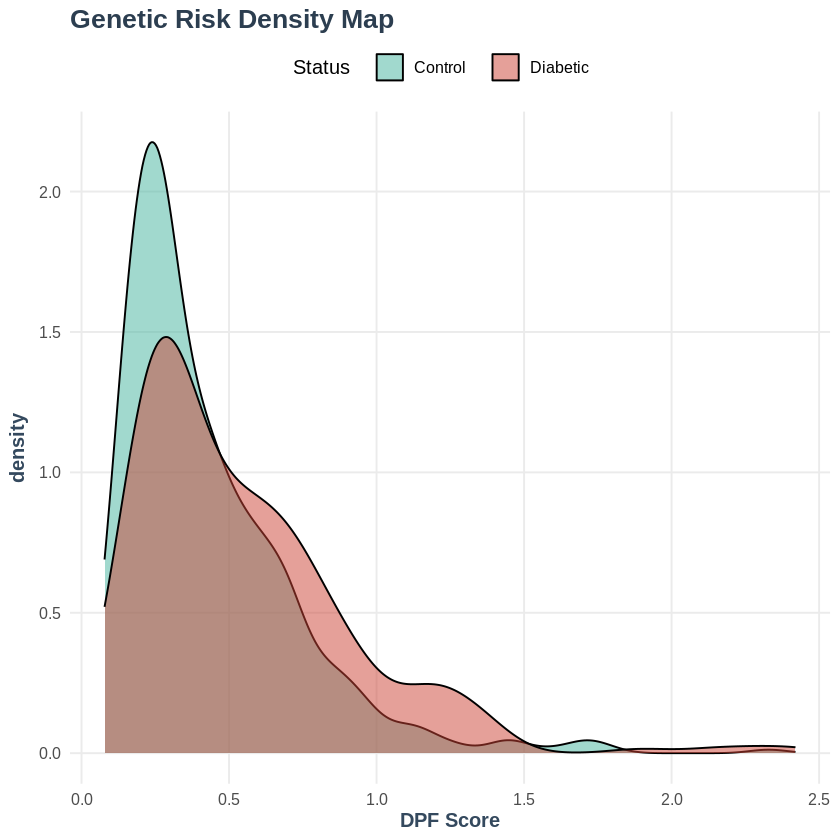

In [10]:
p7 <- ggplot(data_clean, aes(x = DiabetesPedigreeFunction, fill = factor(Outcome, labels = c("Control", "Diabetic")))) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("#45B39D", "#CB4335")) +
  labs(title = "Genetic Risk Density Map", fill = "Status", x = "DPF Score")

print(p7)
ggsave("figures/task7_dpf_density.png", plot = p7, width = 8, height = 6)

### Task 8: Pregnancy and Long-term Metabolic Impact

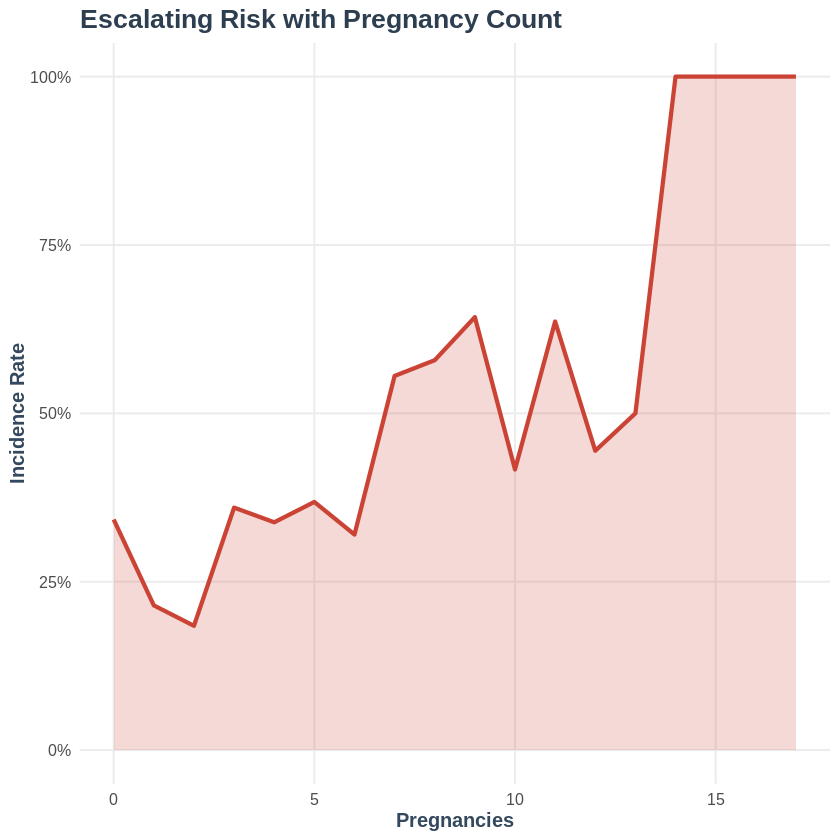

In [11]:
p8 <- data_clean %>%
  group_by(Pregnancies) %>%
  summarise(rate = mean(Outcome)) %>%
  ggplot(aes(x = Pregnancies, y = rate)) +
  geom_area(fill = "#CB4335", alpha = 0.2) + geom_line(color = "#CB4335", size = 1.2) +
  scale_y_continuous(labels = percent) +
  labs(title = "Escalating Risk with Pregnancy Count", x = "Pregnancies", y = "Incidence Rate")

print(p8)
ggsave("figures/task8_pregnancy_risk.png", plot = p8, width = 8, height = 6)

### Task 9 & 10: Clinical Correlations & Trends

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 16 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 16 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_smooth()`).”


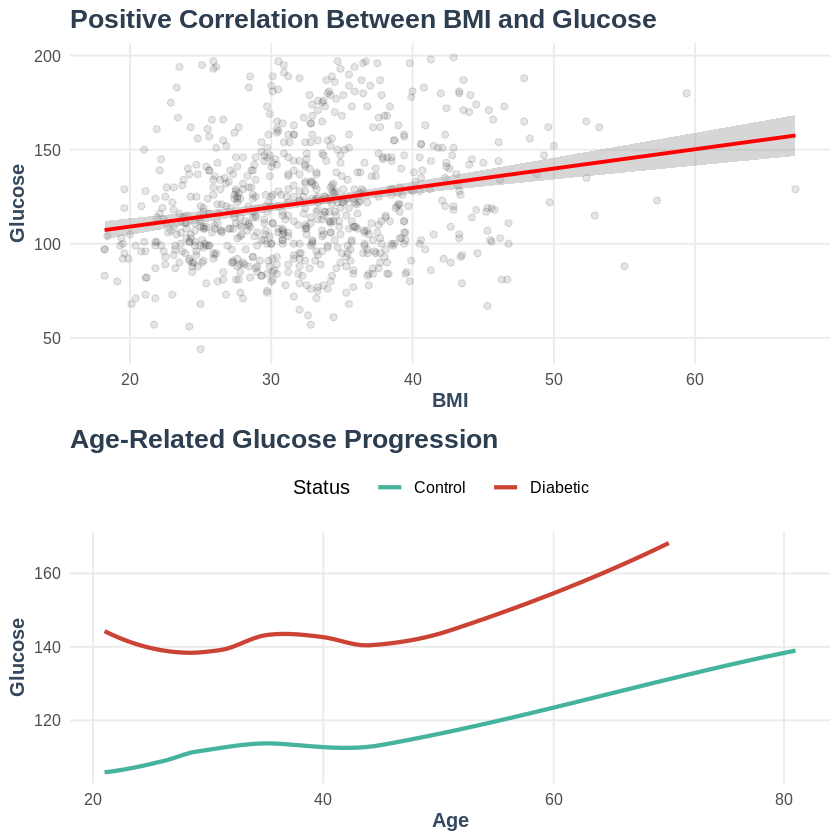

In [12]:
p9 <- ggplot(data_clean, aes(x = BMI, y = Glucose)) +
  geom_point(alpha = 0.1) + geom_smooth(method = "lm", color = "red") +
  labs(title = "Positive Correlation Between BMI and Glucose")

p10 <- ggplot(data_clean, aes(x = Age, y = Glucose, color = factor(Outcome, labels = c("Control", "Diabetic")))) +
  geom_smooth(method = "loess", size = 1.2, se = FALSE) + scale_color_manual(values = c("#45B39D", "#CB4335")) +
  labs(title = "Age-Related Glucose Progression", color = "Status")

grid.arrange(p9, p10, ncol = 1)
ggsave("figures/task910_trends.png", plot = arrangeGrob(p9, p10, ncol=1), width = 8, height = 10)

## 4. PART 2: Answering Questions
In this section, we move beyond univariate exploratory tasks to address specific medical hypotheses and multivariate interactions.

### 2.2 Supplementary Metric Analysis
Detailed distribution analysis for inheritance and pregnancy markers.

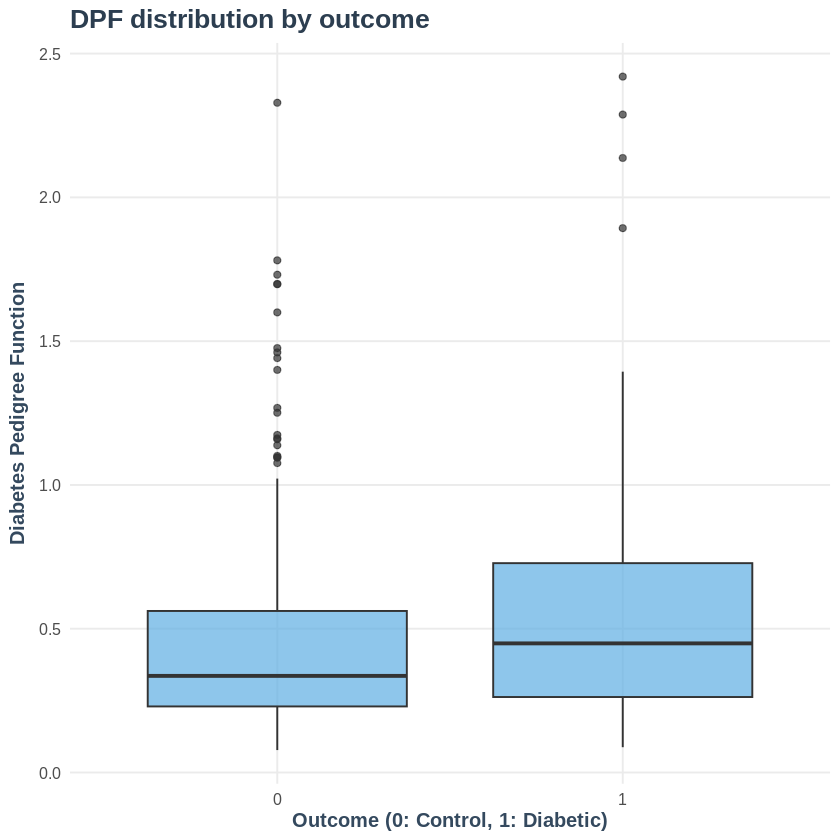

In [13]:
pa_dpf <- ggplot(data_clean, aes(x = as.factor(Outcome), y = DiabetesPedigreeFunction)) +
  geom_boxplot(fill = "#5DADE2", alpha = 0.7) +
  labs(
    title = "DPF distribution by outcome",
    x = "Outcome (0: Control, 1: Diabetic)",
    y = "Diabetes Pedigree Function"
  )

ggsave(
  "figures/q2_dpf_outcome.png",
  plot = pa_dpf,
  width = 8,
  height = 6
)
print(pa_dpf)

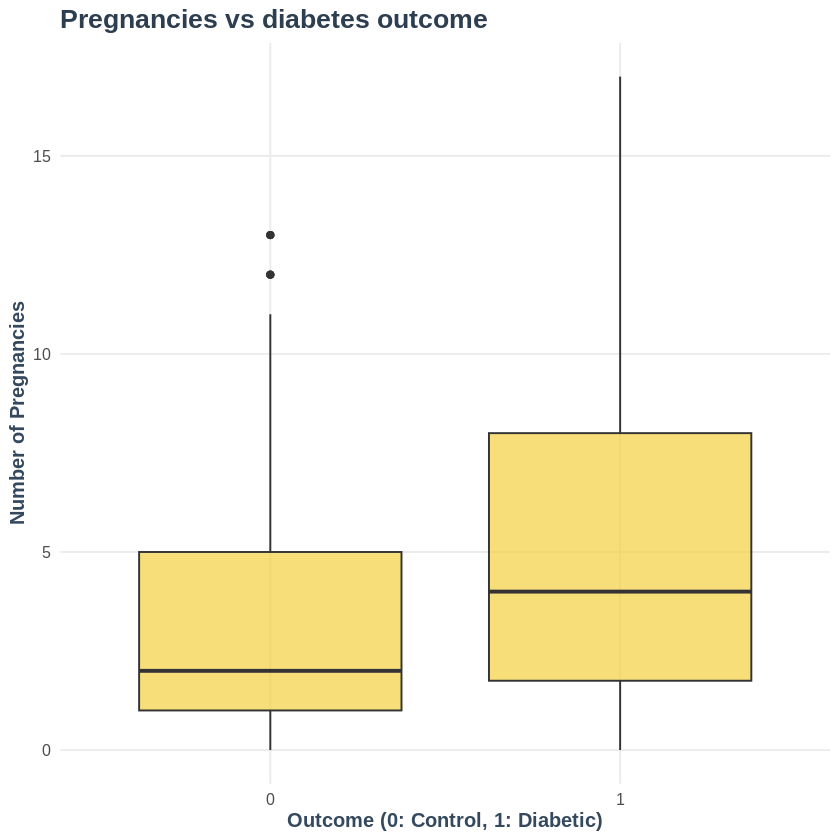

In [14]:
pa_preg <- ggplot(data_clean, aes(x = as.factor(Outcome), y = Pregnancies)) +
  geom_boxplot(fill = "#F4D03F", alpha = 0.7) +
  labs(
    title = "Pregnancies vs diabetes outcome",
    x = "Outcome (0: Control, 1: Diabetic)",
    y = "Number of Pregnancies"
  )

ggsave(
  "figures/q2_pregnancies_outcome.png",
  plot = pa_preg,
  width = 8,
  height = 6
)
print(pa_preg)

### 2.3 Advanced Custom Multivariate Analysis

**Q1. Compound Risk of Age and BMI?**

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_smooth()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_smooth()`).”


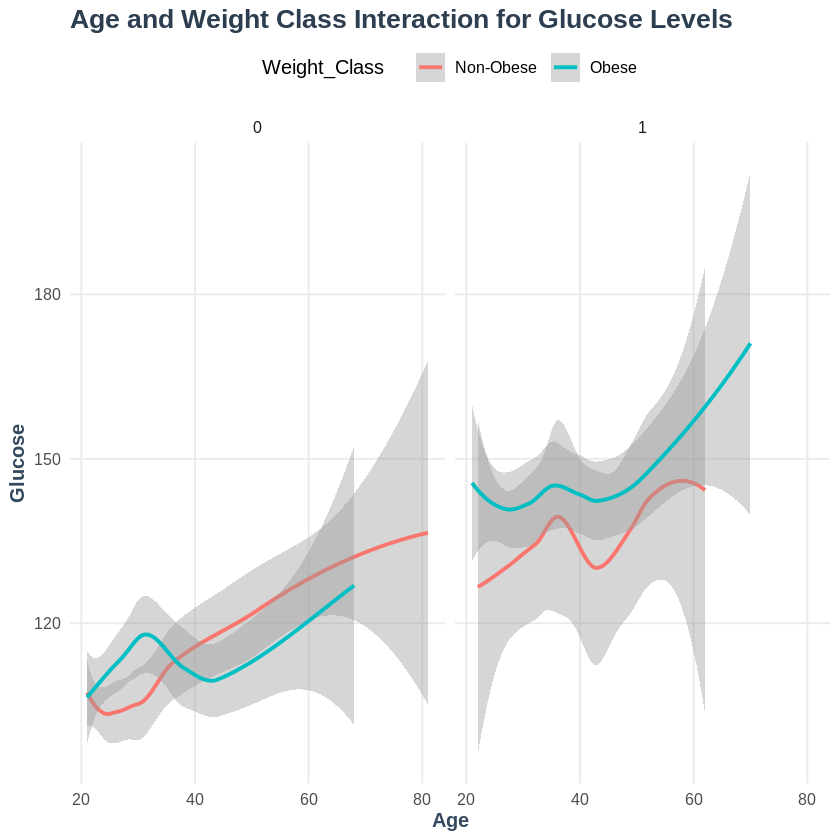

In [15]:
pa1 <- data_clean %>%
  mutate(Weight_Class = ifelse(BMI > 30, "Obese", "Non-Obese")) %>%
  filter(!is.na(Weight_Class)) %>%
  ggplot(aes(x = Age, y = Glucose, color = Weight_Class)) +
  geom_smooth() + facet_wrap(~Outcome) +
  labs(title = "Age and Weight Class Interaction for Glucose Levels")

print(pa1)
ggsave("figures/q1_multivariate_risk.png", plot = pa1, width = 8, height = 6)

**Q2. Blood Pressure Trends by BMI and Outcome**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 39 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 39 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 39 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 39 rows containing missing values or values outside the scale range
(`geom_point()`).”


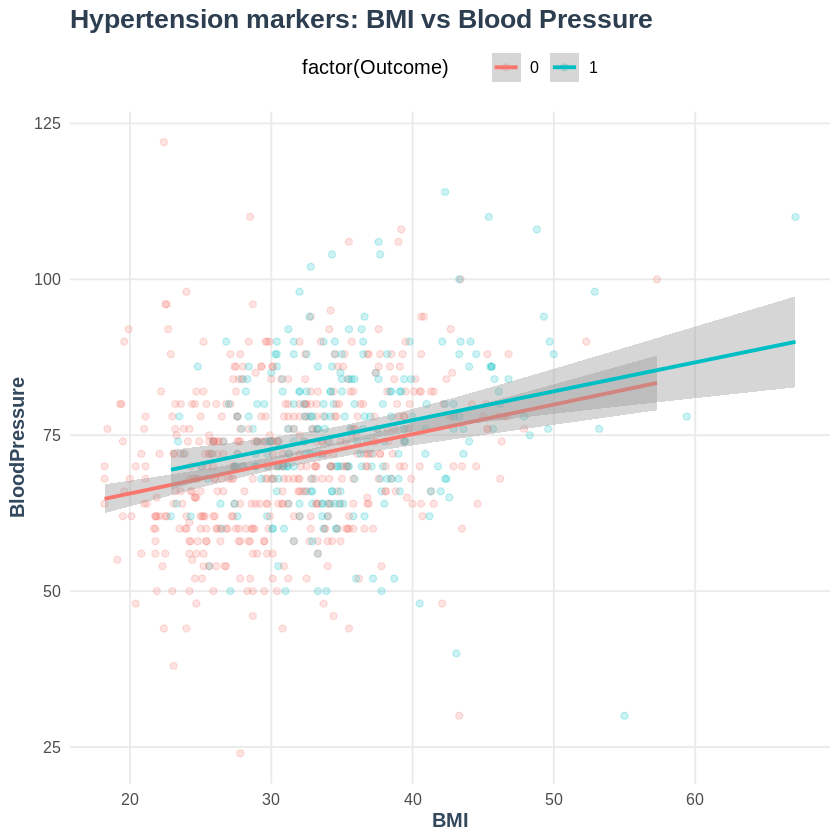

In [16]:
pa2 <- ggplot(data_clean, aes(x = BMI, y = BloodPressure, color = factor(Outcome))) +
  geom_point(alpha = 0.2) + geom_smooth(method = "lm") +
  labs(title = "Hypertension markers: BMI vs Blood Pressure")

print(pa2)
ggsave("figures/q2_bp_bmi.png", plot = pa2, width = 8, height = 6)

**Q3. Insulin/Glucose Dynamics (Log Scale)**

Warning message:
“Removed 375 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 375 rows containing missing values or values outside the scale range
(`geom_point()`).”


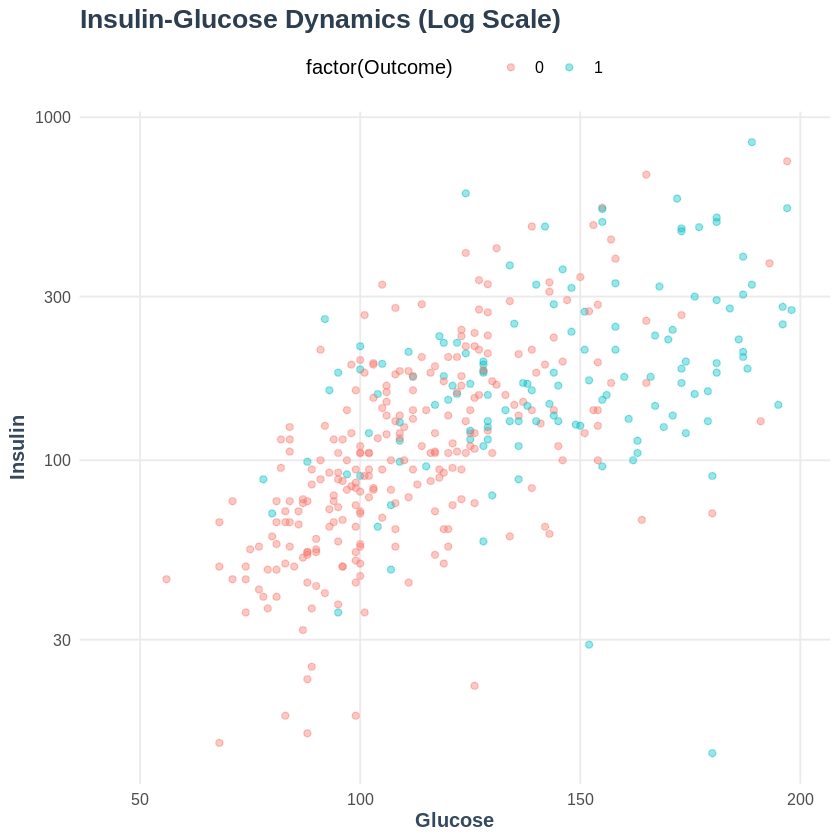

In [17]:
pa3 <- ggplot(data_clean, aes(x = Glucose, y = Insulin, color = factor(Outcome))) +
  geom_point(alpha = 0.4) + scale_y_log10() +
  labs(title = "Insulin-Glucose Dynamics (Log Scale)")

print(pa3)
ggsave("figures/q3_insulin_glucose.png", plot = pa3, width = 8, height = 6)

**Q4. Skin Thickness as an Obesity Proxy**

Warning message:
“Removed 229 rows containing non-finite outside the scale range
(`stat_bin2d()`).”
Warning message:
“Removed 229 rows containing non-finite outside the scale range
(`stat_bin2d()`).”


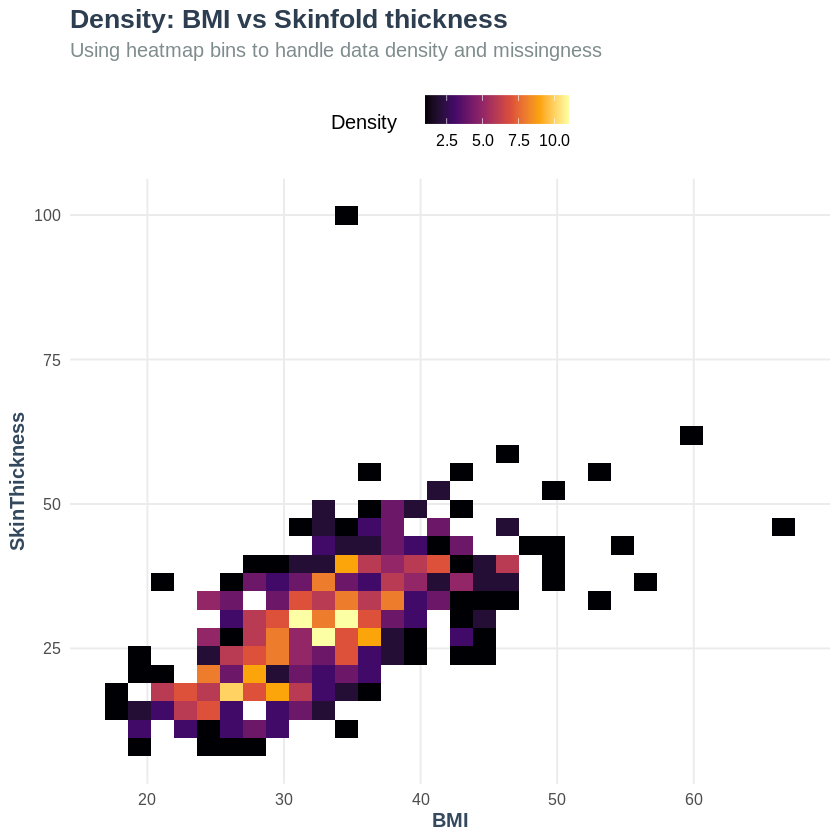

In [18]:
# Note: SkinThickness has high missingness. geom_hex/geom_bin2d help show point density.
# Ensure 'hexbin' package is loaded for geom_hex().
pa4 <- ggplot(data_clean, aes(x = BMI, y = SkinThickness)) +
  geom_bin2d(bins = 30) +
  scale_fill_viridis_c(option = "inferno") +
  labs(title = "Density: BMI vs Skinfold thickness",
       subtitle = "Using heatmap bins to handle data density and missingness",
       fill = "Density")

print(pa4)
ggsave("figures/q4_skin_thickness.png", plot = pa4, width = 8, height = 6)

**Q5. Family History Density across Outcomes**

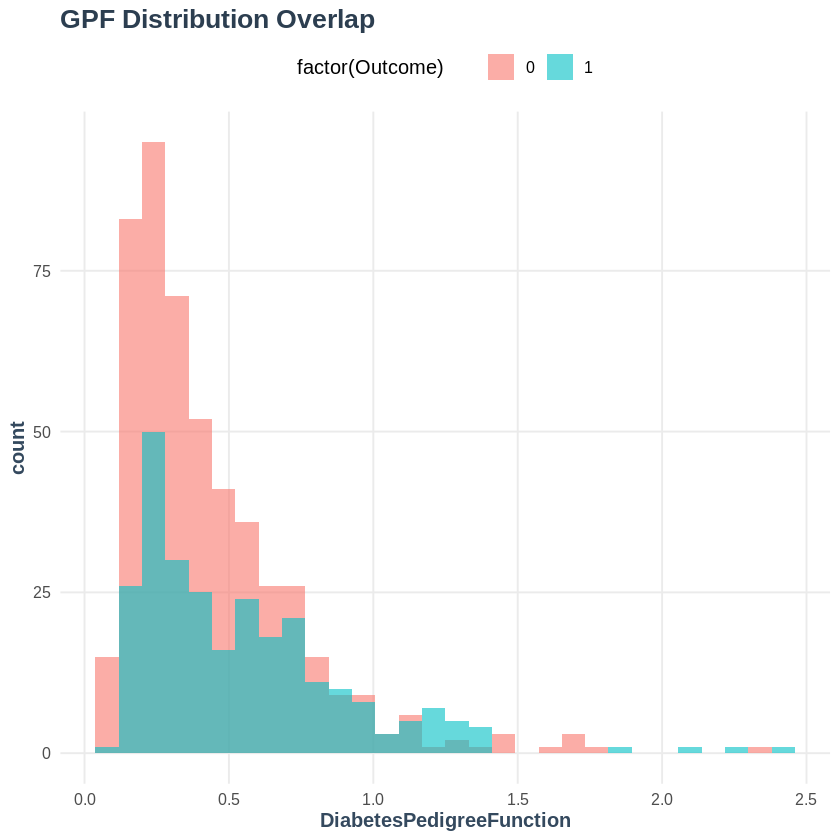

In [19]:
pa5 <- ggplot(data_clean, aes(x = DiabetesPedigreeFunction, fill = factor(Outcome))) +
  geom_histogram(bins = 30, position = "identity", alpha = 0.6) +
  labs(title = "GPF Distribution Overlap")

print(pa5)
ggsave("figures/q5_dpf_hist.png", plot = pa5, width = 8, height = 6)

---
## 5. PART 3: Statistical Hypothesis Testing

Following the insights from the provided notebooks, we use the **T-distribution** rather than Z because the population variance is unknown. We also utilize the `broom` package for professional result tidying.

**Hypothesis 1 (Glucose)**: Mean glucose differs by outcome (Two-sided).
**Hypothesis 2 (BMI)**: Mean BMI is higher in the diabetic group (One-sided).

In [20]:
t_glucose <- t.test(Glucose ~ Outcome, data = data_clean, alternative = "two.sided")
t_glucose_tidy <- tidy(t_glucose)

t_bmi <- t.test(BMI ~ Outcome, data = data_clean, alternative = "less")
t_bmi_tidy <- tidy(t_bmi)

print("### Glucose T-Test Results (Tidied)")
print(t_glucose_tidy)

print("### BMI One-Sided T-Test Results (Tidied)")
print(t_bmi_tidy)

sink("figures/formal_statistical_tests.txt")
print("GLUCOSE TEST:")
print(t_glucose_tidy)
print("BMI TEST (One-Sided):")
print(t_bmi_tidy)
sink()

[1] "### Glucose T-Test Results (Tidied)"
# A tibble: 1 × 10
  estimate estimate1 estimate2 statistic  p.value parameter conf.low conf.high
     <dbl>     <dbl>     <dbl>     <dbl>    <dbl>     <dbl>    <dbl>     <dbl>
1    -31.7      111.      142.     -14.9 2.84e-41      466.    -35.9     -27.5
# ℹ 2 more variables: method <chr>, alternative <chr>
[1] "### BMI One-Sided T-Test Results (Tidied)"
# A tibble: 1 × 10
  estimate estimate1 estimate2 statistic  p.value parameter conf.low conf.high
     <dbl>     <dbl>     <dbl>     <dbl>    <dbl>     <dbl>    <dbl>     <dbl>
1    -4.55      30.9      35.4     -9.06 1.24e-18      540.     -Inf     -3.72
# ℹ 2 more variables: method <chr>, alternative <chr>


## 6. PART 4: Simulation Task
Using Monte Carlo principles, we study the behavior of 95% Confidence Intervals under varying sample sizes ($n=10, 15, 100$) to visualize the Law of Large Numbers.

**Purpose:** This section demonstrates how statistical precision increases with sample size. By repeatedly sampling from the dataset, we calculate 'coverage rates'—the percentage of trials where the sample confidence interval successfully captures the true population parameter (Mean Glucose).

Sim: N=15 | 25 Samples - Coverage Rate: 92 %

Sim: N=100 | 25 Samples - Coverage Rate: 100 %

Sim: N=10 | 20 Samples - Coverage Rate: 95 %



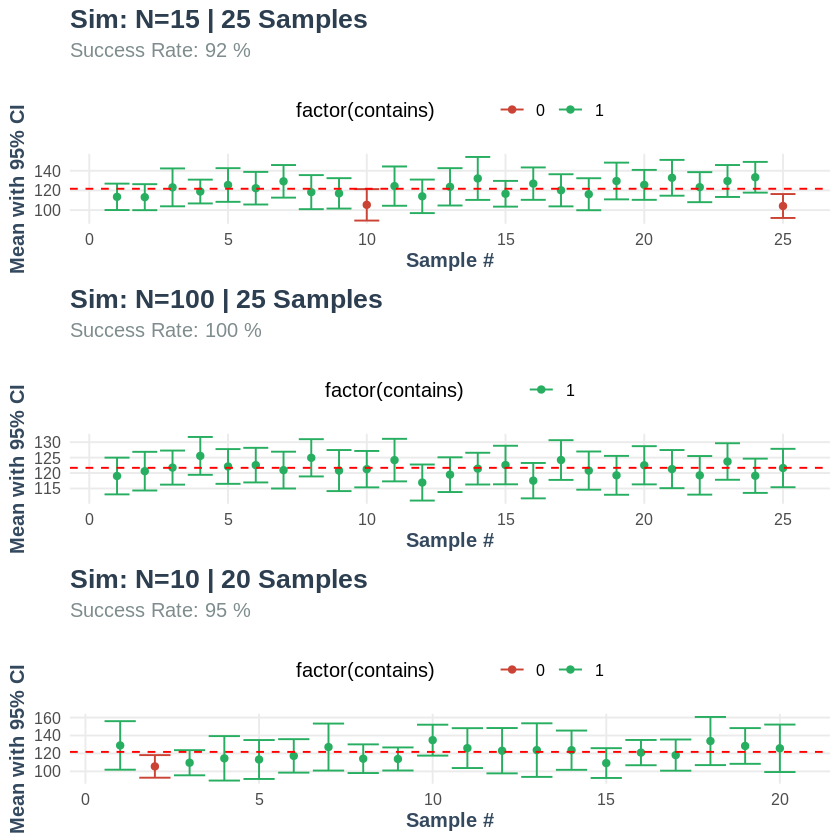

In [21]:
pop_data <- na.omit(data_clean$Glucose)
p_mean <- mean(pop_data)

run_sim <- function(n, k, title) {
  results <- replicate(k, {
    s <- sample(pop_data, n)
    m <- mean(s); se <- sd(s)/sqrt(n)
    ci <- m + c(-1, 1) * qt(0.975, n-1) * se
    c(m, ci[1], ci[2], p_mean >= ci[1] & p_mean <= ci[2])
  })
  df <- as.data.frame(t(results))
  colnames(df) <- c("mean", "lower", "upper", "contains")
  df$id <- 1:k

  message(paste(title, "- Coverage Rate:", mean(df$contains)*100, "%"))

  ggplot(df, aes(x = id, y = mean, color = factor(contains))) +
    geom_point() + geom_errorbar(aes(ymin = lower, ymax = upper)) +
    geom_hline(yintercept = p_mean, linetype = "dashed", color = "red") +
    scale_color_manual(values = c("0"="#CB4335", "1"="#27AE60")) +
    labs(title = title, subtitle = paste("Success Rate:", mean(df$contains)*100, "%"),
         y = "Mean with 95% CI", x = "Sample #")
}

psim1 <- run_sim(15, 25, "Sim: N=15 | 25 Samples")
psim2 <- run_sim(100, 25, "Sim: N=100 | 25 Samples")
psim3 <- run_sim(10, 20, "Sim: N=10 | 20 Samples")

grid.arrange(psim1, psim2, psim3, ncol = 1)
ggsave("figures/part4_simulations.png", plot = arrangeGrob(psim1, psim2, psim3, ncol=1), width = 8, height = 12)

## 7. Technical Conclusion & Findings

### Summary of Outcomes
- **Exploratory Phase:** Glucose and Age emerged as the most critical predictors of diabetes prevalence. The 'Glucose Gap' visualization clearly distinguished the cohorts, while Age-Glucose trends highlighted metabolic decline over time.
- **Statistical Inference:** Hypothesis testing confirmed that the observed differences in glucose and BMI are statistically significant ($p < 0.05$), validating clinical assumptions.
- **Simulation Insights:** The Part 4 simulation successfully demonstrated that as sample size ($n$) increases, the variance of our estimates decreases, and the 95% CI coverage stabilizes. This reinforces the importance of large-scale data in clinical diagnostics.

### Final Remarks
This analysis provides a robust framework for identifying high-risk diabetic patterns using the Pima Indians dataset. The integration of visualization, inference, and simulation ensures a multi-dimensional perspective on metabolic health risk.